In [1]:
import os
import sys
import numpy as np
import cv2
import math
from pyquaternion import Quaternion

from mmdet3d.datasets.convert_utils import *
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.geometry_utils import view_points

In [2]:
nusc = NuScenes(
    version='v1.0-mini',
    dataroot='/home/alan_khang/dev/mmdetection3d/data/nuscenes',
    verbose=True)


Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.610 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


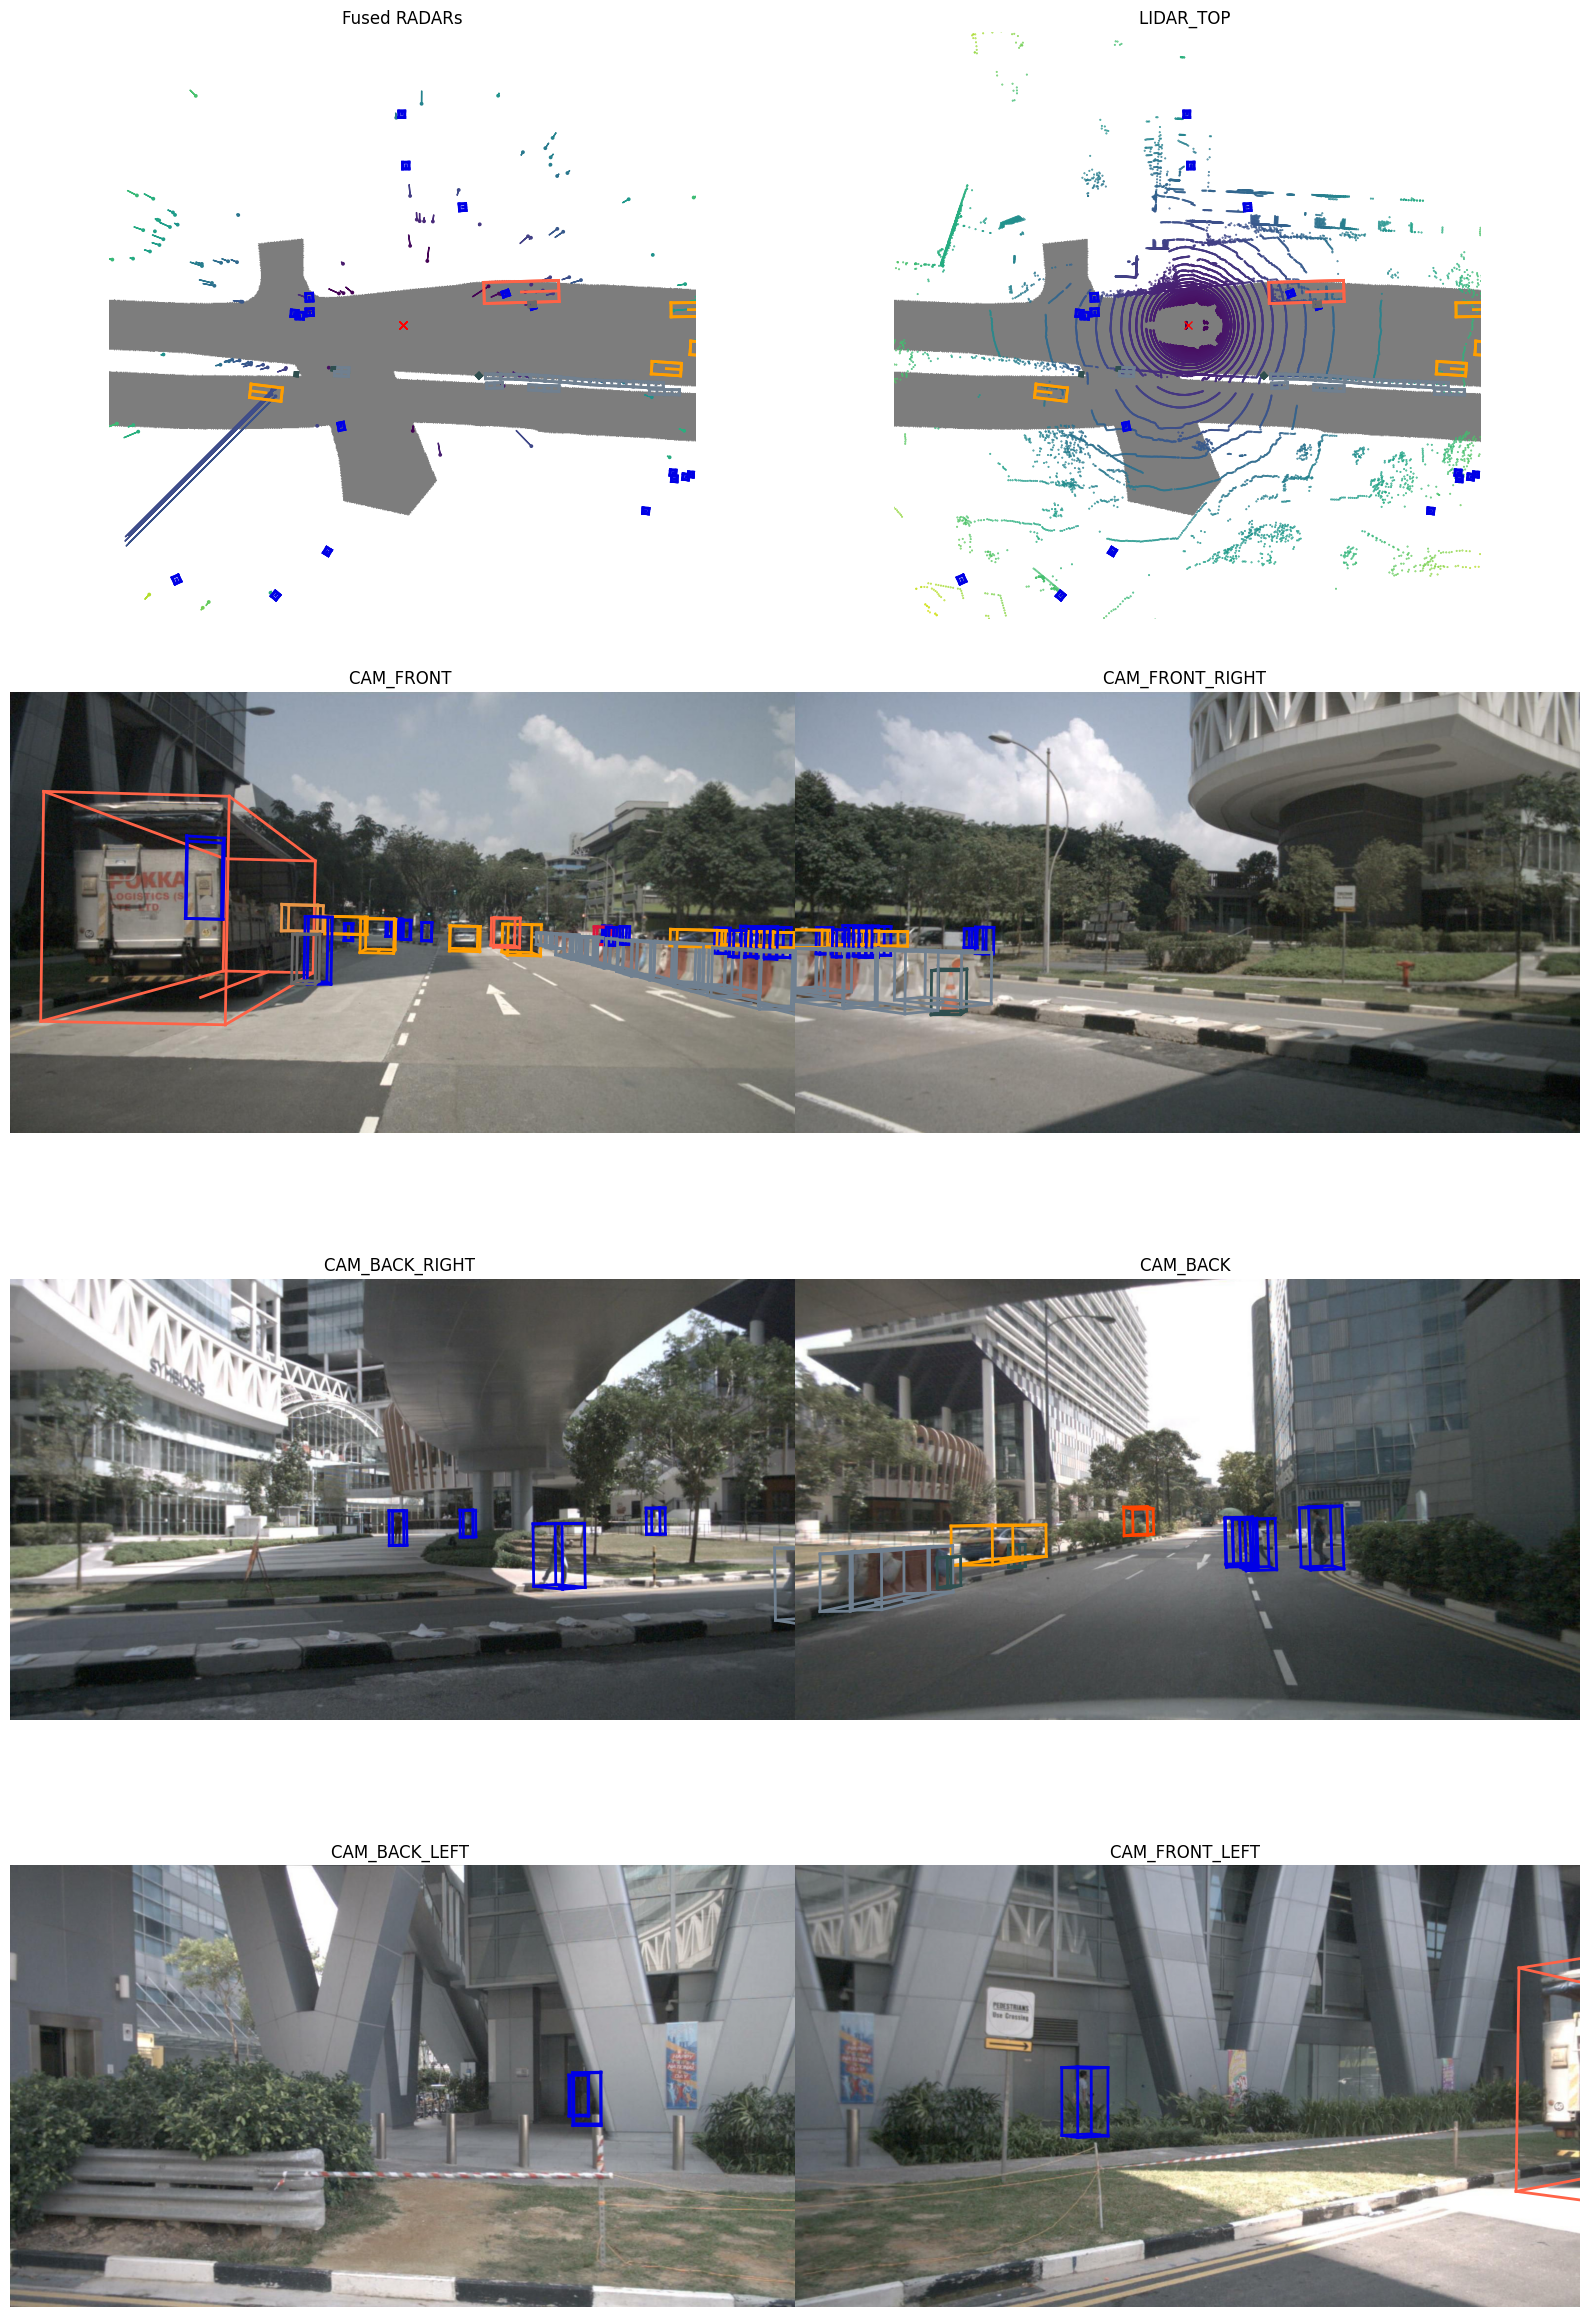

In [3]:
nusc.render_sample('ca9a282c9e77460f8360f564131a8af5') 

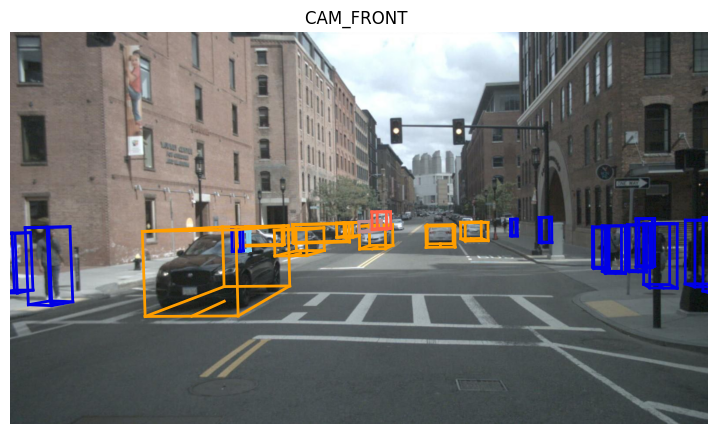

In [3]:
nusc.render_sample_data('fa18edcec56e4a87a5cbd9e04a2f3a09')  

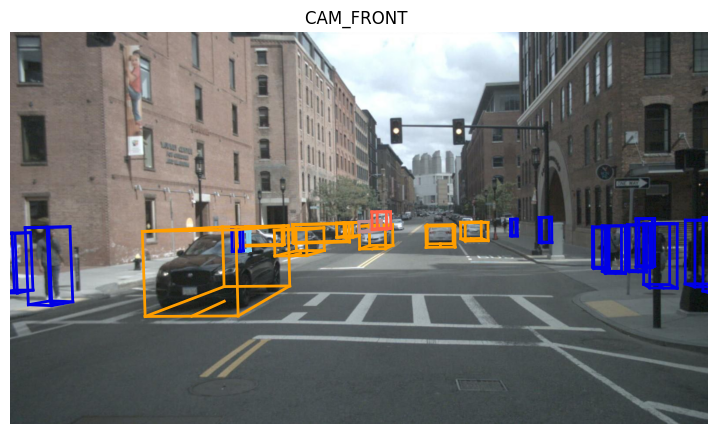

In [4]:
nusc.render_sample_data('fa18edcec56e4a87a5cbd9e04a2f3a09')

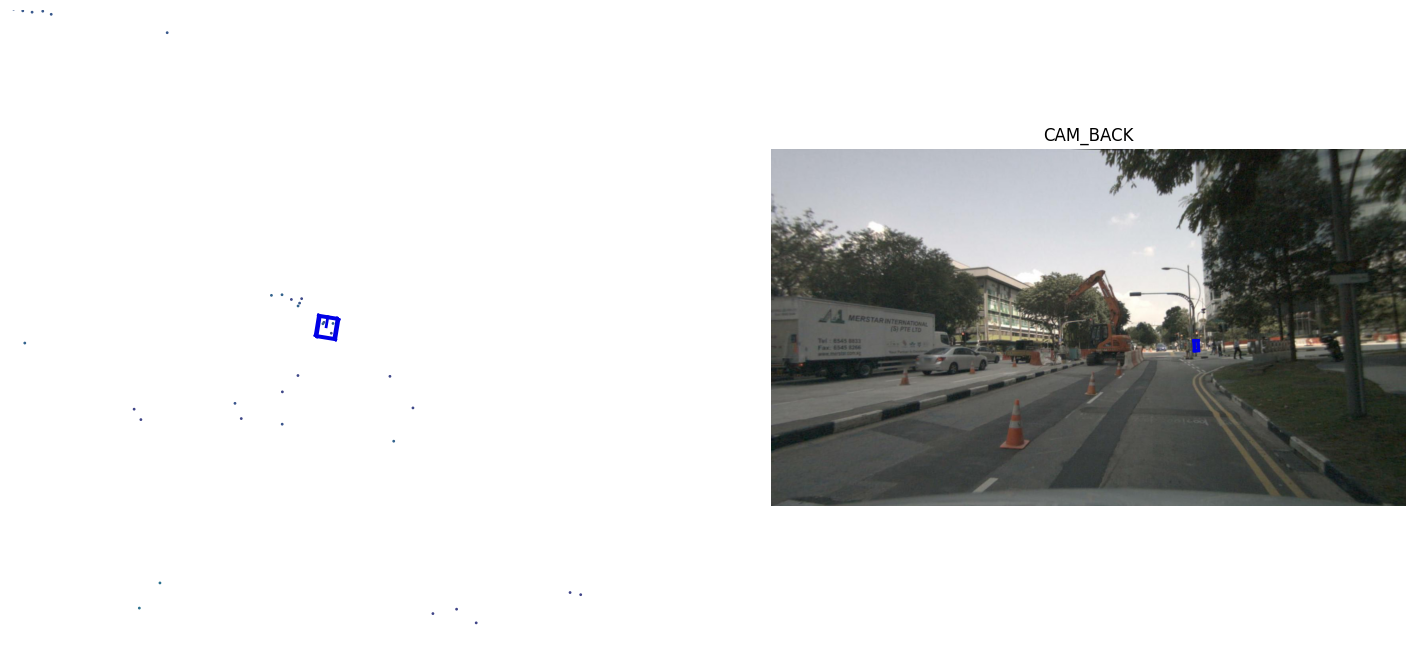

In [6]:
nusc.render_annotation('8bb63134d48840aaa2993f490855ff0d')

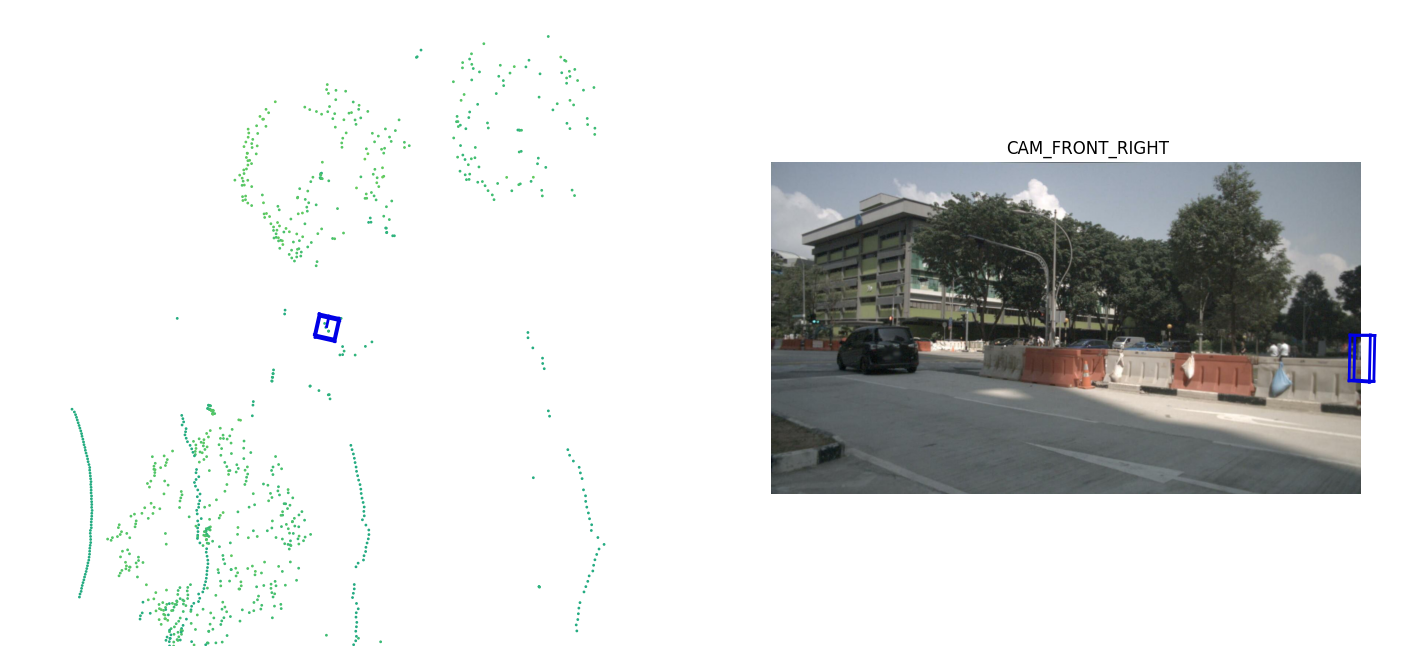

In [7]:
nusc.render_instance('c08be936e0394352b11760ede982d6fd')

In [5]:
data_path, box_list, cam_intrinsic = nusc.get_sample_data('3d1b68481c894b0c84291b7d923e2e23') 

In [7]:
box_list

[label: nan, score: nan, xyz: [2.11, 0.63, 41.49], wlh: [2.00, 4.73, 1.48], rot axis: [-0.59, 0.58, -0.57], ang(degrees): -118.51, ang(rad): -2.07, vel: nan, nan, nan, name: vehicle.car, token: a62c4ab0cca142ebafb73b96a173743e,
 label: nan, score: nan, xyz: [-7.10, 0.82, 23.88], wlh: [1.95, 5.03, 1.67], rot axis: [0.97, -0.18, 0.16], ang(degrees): 91.62, ang(rad): 1.60, vel: nan, nan, nan, name: vehicle.car, token: 9358fa536f5647138a7682903e5237d7,
 label: nan, score: nan, xyz: [17.06, -0.00, 59.31], wlh: [1.48, 3.83, 1.69], rot axis: [0.58, 0.57, -0.58], ang(degrees): 120.71, ang(rad): 2.11, vel: nan, nan, nan, name: vehicle.car, token: 4f5fdf66b463494fb53adddd9ef0c819,
 label: nan, score: nan, xyz: [-14.39, 1.26, 22.18], wlh: [1.80, 4.33, 1.70], rot axis: [0.99, -0.08, 0.07], ang(degrees): 90.35, ang(rad): 1.58, vel: nan, nan, nan, name: vehicle.car, token: 14b5b89c50814ec898e99c49783b99e4,
 label: nan, score: nan, xyz: [-7.39, 0.96, 7.37], wlh: [1.93, 4.83, 1.52], rot axis: [0.57, 0

In [8]:
box_list[4].orientation

Quaternion(0.4892796597463117, 0.49709144142862377, 0.5034131405664717, -0.509981100945857)

In [9]:
box_list[0].orientation

Quaternion(-0.5111864699639533, -0.5046377991192134, 0.4958481450370683, -0.4880201857394907)

In [8]:
from scipy.spatial.transform import Rotation as R

In [9]:
global_2_ego_trans = np.array([411.3940085709597, 1181.1288333610287, 0.0])
global_2_ego_quat = np.array([0.5719976683022334, -0.0020681756810697035, 0.011639346518095882, -0.820170052927313])
global_2_ego_rot_mat = R.from_quat(global_2_ego_quat, scalar_first=True).as_matrix()
global_2_ego_trans_mat = np.eye(4)
global_2_ego_trans_mat[:3, :3] = global_2_ego_rot_mat
global_2_ego_trans_mat[:3, 3] = global_2_ego_trans

ego_2_sensor_trans = np.array([1.5508477543, -0.493404796419, 1.49574800619])
ego_2_sensor_quat = np.array([0.2060347966337182, -0.2026940577919598, 0.6824507824531167, -0.6713610884174485])
ego_2_sensor_rot_mat = R.from_quat(ego_2_sensor_quat, scalar_first=True).as_matrix()
ego_2_sensor_trans_mat = np.eye(4)
ego_2_sensor_trans_mat[:3, :3] = ego_2_sensor_rot_mat
ego_2_sensor_trans_mat[:3, 3] = ego_2_sensor_trans

camera_intr = np.array([
    [1260.8474446004698, 0.0, 807.968244525554],
    [0.0, 1260.8474446004698, 495.3344268742088],
    [0.0, 0.0, 1.0]
])

obj_trans_wrt_global = np.array([397.032, 1166.701, 0.466])
obj_quat_wrt_global = np.array([-0.978516182386297, 0.0, 0.0, 0.2061700288794352])
obj_rot_mat_wrt_global = R.from_quat(obj_quat_wrt_global, scalar_first=True).as_matrix()
obj_coord_wrt_global = np.eye(4)
obj_coord_wrt_global[:3, :3] = obj_rot_mat_wrt_global
obj_coord_wrt_global[:3, 3] = obj_trans_wrt_global

In [10]:
obj_coord_wrt_sensor = np.linalg.inv(ego_2_sensor_trans_mat) @ np.linalg.inv(global_2_ego_trans_mat) @ obj_coord_wrt_global

In [11]:
obj_trans_wrt_sensor = obj_coord_wrt_sensor[:3, 3]
obj_rot_mat_wrt_sensor = obj_coord_wrt_sensor[:3, :3]

In [12]:
obj_trans_wrt_sensor

array([-9.6746864 ,  0.8970339 , 16.06139029])

In [13]:
obj_rot_mat_wrt_sensor

array([[-0.60422495,  0.79673667,  0.01108523],
       [-0.00569103,  0.00959649, -0.99993776],
       [-0.79679346, -0.60425043, -0.00126419]])

In [14]:
Quaternion(R.from_matrix(obj_rot_mat_wrt_sensor).as_quat(scalar_first=True)).degrees

142.934435780795

In [15]:
Quaternion(R.from_matrix(obj_rot_mat_wrt_sensor).as_quat(scalar_first=True)).yaw_pitch_roll

(-2.219635747047369, 0.01108545783450614, 1.5720605936812937)

In [16]:
math.degrees(Quaternion(R.from_matrix(obj_rot_mat_wrt_sensor).as_quat(scalar_first=True)).yaw_pitch_roll[1])

0.6351499478874348

In [17]:
orientation = Quaternion(R.from_matrix(obj_rot_mat_wrt_sensor).as_quat(scalar_first=True))

In [18]:
orientation

Quaternion(0.31784719326930216, 0.311224494166906, 0.6354300973869219, -0.631142667941431)

In [19]:
orientation.axis[0]

0.32824672867659815

In [20]:
orientation.axis[1]

0.6701845602745248

In [21]:
orientation.axis[2]

-0.6656626324819155

In [22]:
orientation.rotation_matrix

array([[-0.60422495,  0.79673667,  0.01108523],
       [-0.00569103,  0.00959649, -0.99993776],
       [-0.79679346, -0.60425043, -0.00126419]])

In [ ]:
box_list[9].orientation

Quaternion(0.31784719326930233, 0.3112244941669061, 0.6354300973869218, -0.6311426679414311)

In [ ]:
math.degrees(Quaternion(obj_quat_wrt_global).yaw_pitch_roll[0])

-23.79600000181823

In [ ]:
Quaternion(obj_quat_wrt_global).degrees

-23.796000001818165

In [ ]:
nusc.box_velocity(box_list[9].token)

array([0.        , 0.        , 0.04200873])

In [ ]:
box_list[9].velocity

array([nan, nan, nan])

In [ ]:
sample = nusc.sample[0]

In [ ]:
cam_token = sample['data']['CAM_FRONT_RIGHT']

In [ ]:
cam_path, _, cam_intrinsic = nusc.get_sample_data(cam_token)

In [ ]:
cam_intrinsic

array([[1.26084744e+03, 0.00000000e+00, 8.07968245e+02],
       [0.00000000e+00, 1.26084744e+03, 4.95334427e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [ ]:
nusc.get('sample_annotation', sample['anns'][0]) 

{'token': 'ef63a697930c4b20a6b9791f423351da',
 'sample_token': 'ca9a282c9e77460f8360f564131a8af5',
 'instance_token': '6dd2cbf4c24b4caeb625035869bca7b5',
 'visibility_token': '1',
 'attribute_tokens': ['4d8821270b4a47e3a8a300cbec48188e'],
 'translation': [373.256, 1130.419, 0.8],
 'size': [0.621, 0.669, 1.642],
 'rotation': [0.9831098797903927, 0.0, 0.0, -0.18301629506281616],
 'prev': '',
 'next': '7987617983634b119e383d8a29607fd7',
 'num_lidar_pts': 1,
 'num_radar_pts': 0,
 'category_name': 'human.pedestrian.adult'}

In [ ]:
sample['token']

'ca9a282c9e77460f8360f564131a8af5'

In [ ]:
nusc.get('sample', sample['token'])

{'token': 'ca9a282c9e77460f8360f564131a8af5',
 'timestamp': 1532402927647951,
 'prev': '',
 'next': '39586f9d59004284a7114a68825e8eec',
 'scene_token': 'cc8c0bf57f984915a77078b10eb33198',
 'data': {'RADAR_FRONT': '37091c75b9704e0daa829ba56dfa0906',
  'RADAR_FRONT_LEFT': '11946c1461d14016a322916157da3c7d',
  'RADAR_FRONT_RIGHT': '491209956ee3435a9ec173dad3aaf58b',
  'RADAR_BACK_LEFT': '312aa38d0e3e4f01b3124c523e6f9776',
  'RADAR_BACK_RIGHT': '07b30d5eb6104e79be58eadf94382bc1',
  'LIDAR_TOP': '9d9bf11fb0e144c8b446d54a8a00184f',
  'CAM_FRONT': 'e3d495d4ac534d54b321f50006683844',
  'CAM_FRONT_RIGHT': 'aac7867ebf4f446395d29fbd60b63b3b',
  'CAM_BACK_RIGHT': '79dbb4460a6b40f49f9c150cb118247e',
  'CAM_BACK': '03bea5763f0f4722933508d5999c5fd8',
  'CAM_BACK_LEFT': '43893a033f9c46d4a51b5e08a67a1eb7',
  'CAM_FRONT_LEFT': 'fe5422747a7d4268a4b07fc396707b23'},
 'anns': ['ef63a697930c4b20a6b9791f423351da',
  '6b89da9bf1f84fd6a5fbe1c3b236f809',
  '924ee6ac1fed440a9d9e3720aac635a0',
  '91e3608f55174a319

In [ ]:
sample_data_token = 'aac7867ebf4f446395d29fbd60b63b3b'
sd_rec = nusc.get('sample_data', sample_data_token)
visibilities=['', '1', '2', '3', '4']

s_rec = nusc.get('sample', sd_rec['sample_token'])
cs_rec = nusc.get('calibrated_sensor', sd_rec['calibrated_sensor_token'])
pose_rec = nusc.get('ego_pose', sd_rec['ego_pose_token'])
camera_intrinsic = np.array(cs_rec['camera_intrinsic'])

# Get all the annotation with the specified visibilties.
ann_recs = [
    nusc.get('sample_annotation', token) for token in s_rec['anns']
]
ann_recs = [
    ann_rec for ann_rec in ann_recs
    if (ann_rec['visibility_token'] in visibilities)
]


In [ ]:
box = nusc.get_box(ann_recs[0]['token'])

In [ ]:
repro_recs = []

for ann_rec in ann_recs:
    # Augment sample_annotation with token information.
    ann_rec['sample_annotation_token'] = ann_rec['token']
    ann_rec['sample_data_token'] = sample_data_token

    # Get the box in global coordinates.
    box = nusc.get_box(ann_rec['token'])

    # Move them to the ego-pose frame.
    box.translate(-np.array(pose_rec['translation']))
    box.rotate(Quaternion(pose_rec['rotation']).inverse)

    # Move them to the calibrated sensor frame.
    box.translate(-np.array(cs_rec['translation']))
    box.rotate(Quaternion(cs_rec['rotation']).inverse)

    # Filter out the corners that are not in front of the calibrated
    # sensor.
    corners_3d = box.corners()
    in_front = np.argwhere(corners_3d[2, :] > 0).flatten()
    corners_3d = corners_3d[:, in_front]

    # Project 3d box to 2d.
    corner_coords = view_points(corners_3d, camera_intrinsic,
                                True).T[:, :2].tolist()

    # Keep only corners that fall within the image.
    final_coords = post_process_coords(corner_coords)

    # Skip if the convex hull of the re-projected corners
    # does not intersect the image canvas.
    if final_coords is None:
        continue
    else:
        min_x, min_y, max_x, max_y = final_coords

    # Generate dictionary record to be included in the .json file.
    repro_rec = generate_record(ann_rec, min_x, min_y, max_x, max_y,
                                'nuscenes')

    # if repro_rec is None, we do not append it into repre_recs
    if repro_rec is not None:
        loc = box.center.tolist()

        dim = box.wlh
        dim[[0, 1, 2]] = dim[[1, 2, 0]]  # convert wlh to our lhw
        dim = dim.tolist()

        rot = box.orientation.yaw_pitch_roll[0]
        rot = [-rot]  # convert the rot to our cam coordinate

        global_velo2d = nusc.box_velocity(box.token)[:2]
        global_velo3d = np.array([*global_velo2d, 0.0])
        e2g_r_mat = Quaternion(pose_rec['rotation']).rotation_matrix
        c2e_r_mat = Quaternion(cs_rec['rotation']).rotation_matrix
        cam_velo3d = global_velo3d @ np.linalg.inv(
            e2g_r_mat).T @ np.linalg.inv(c2e_r_mat).T
        velo = cam_velo3d[0::2].tolist()

        repro_rec['bbox_3d'] = loc + dim + rot
        repro_rec['velocity'] = velo

        center_3d = np.array(loc).reshape([1, 3])
        center_2d_with_depth = points_cam2img(
            center_3d, camera_intrinsic, with_depth=True)
        center_2d_with_depth = center_2d_with_depth.squeeze().tolist()
        repro_rec['center_2d'] = center_2d_with_depth[:2]
        repro_rec['depth'] = center_2d_with_depth[2]
        # normalized center2D + depth
        # if samples with depth < 0 will be removed
        if repro_rec['depth'] <= 0:
            continue

        ann_token = nusc.get('sample_annotation',
                             box.token)['attribute_tokens']
        if len(ann_token) == 0:
            attr_name = 'None'
        else:
            attr_name = nusc.get('attribute', ann_token[0])['name']
        attr_id = nus_attributes.index(attr_name)
        # repro_rec['attribute_name'] = attr_name
        repro_rec['attr_label'] = attr_id

        repro_recs.append(repro_rec)


In [ ]:
box_list[0]

label: nan, score: nan, xyz: [-18.46, 0.37, 36.80], wlh: [0.78, 0.77, 1.71], rot axis: [-0.23, 0.69, -0.69], ang(degrees): -155.03, ang(rad): -2.71, vel: nan, nan, nan, name: human.pedestrian.adult, token: 6b89da9bf1f84fd6a5fbe1c3b236f809

In [ ]:
b = box_list[0]

In [ ]:
b.orientation.yaw_pitch_roll

(2.5086182762655858, 0.011085457834506084, 1.572060593681294)